# COVID-19 Response effect assessment





In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats  as stats
import seaborn as sns; sns.set()
from datetime import datetime
import calendar
import os
from os import listdir
from os.path import isfile, join

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:,.2f}'.format


## Pollution Data

Data collected from https://aqicn.org/

For each country, only one station from the most affected city (usually the capital) was considered.

*TODO: Get data from all stations in the city and take the averages*

Data from the 3 previous years were averaged to compute the daily baseline for pullution. Then, for co (industrial pollution) and no2 (fuel burning -- cars), the ratio between the 2020 data and the baseline was computed.

**co** is not used beuse few countries have these data

In [25]:
data_dir = 'data/'


df_orig_response = pd.read_csv(data_dir + 'pollution_countries.csv')

# df_orig_response = df_orig_response.rename(columns={'date':'Date'})

df_orig_response.sample(10)

Country       City        Date   co  no2   o3  pm10  pm25  so2
331            China      Wuhan  2020-02-05 1.13 0.67 1.95  1.20  1.23 1.08
1633   United States  Manhattan  2020-01-19 0.70 0.46 1.12   nan  0.90  nan
1413          Sweden  Stockholm  2020-04-02  nan 0.61 1.70  1.59  0.78  nan
1530  United Kingdom     London  2020-03-03 1.74 1.68 0.56  1.08  0.98 1.07
28            Brazil  São Paulo  2020-01-27 1.40 1.97 1.12  1.68  1.47 1.80
876            Italy      Milan  2020-05-21 1.00 0.44 6.10  0.34  0.40 0.59
1288           Spain     Madrid  2020-04-24 1.00 0.27 2.40  0.48  0.66 0.62
861            Italy      Milan  2020-05-06 1.00 0.49 5.33  0.35  0.35 0.45
1379          Sweden  Stockholm  2020-02-28  nan 1.55 1.28  1.83  1.02  nan
1075        Portugal     Lisbon  2020-02-18  nan 0.53 1.62  0.81  0.59 0.29

## COVID cases and other statistics

Total confirmed cases and total deaths data from ourworldindata.org. Other statistics were derived fom the base data.



In [26]:
df_orig_cases = pd.read_csv(data_dir + 'total_cases_countries_normalized.csv').rename(columns={'Name':'Country'})

df_orig_cases.sample(10)

Country        Date     Total  Day  TotalDeaths  DailyDeaths  Daily  TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
9647                Jordan  2020-05-15    586.00  136         9.00         0.00   4.00          5.89                0.09                0.00          0.04    57.00        1.01              1.00        101.20                1.00         18.62                0.00
16616                Spain  2020-01-17      0.00   17         0.00         0.00   0.00          0.00                0.00                0.00          0.00      nan         nan               nan           nan                 nan           nan                 nan
3112              Cambodia  2020-02-05      1.00   36         0.00         0.00   0.00          0.01                0.00                0.00          0.00      nan        1.00               nan          1.00                 nan          0.00                 nan
7362             Greenland  2020-04-06     11.00   97         0.00         0.00   1.00         19.63                0.00                0.00          1.78      nan        1.10               nan          7.27                 nan         10.00                 nan
1120               Austria  2020-02-15      0.00   46         0.00         0.00   0.00          0.00                0.00                0.00          0.00      nan         nan               nan           nan                 nan           nan                 nan
5488               Ecuador  2020-05-19 33,582.00  140     2,799.00        63.00 400.00        196.57               16.38                0.37          2.34    63.00        1.01              1.02         57.85               30.45         13.80               30.49
9410               Jamaica  2020-05-15    509.00  136         9.00         0.00   0.00         17.34                0.31                0.00          0.00    41.00        1.00              1.00          1.00                1.00          4.30                0.00
16224             Slovenia  2020-05-14  1,464.00  135       103.00         1.00   1.00         70.59                4.97                0.05          0.05    63.00        1.00              1.01      1,014.42               71.05          1.04                4.04
16443          South Korea  2020-02-16     29.00   47         0.00         0.00   1.00          0.06                0.00                0.00          0.00      nan        1.04               nan         19.75                 nan         16.00                 nan
597    Antigua and Barbuda  2020-05-15     25.00  136         3.00         0.00   0.00         25.96                3.12                0.00          0.00      nan        1.00              1.00          1.00                1.00          0.00                0.00

In [27]:
df_orig = pd.merge(df_orig_response, df_orig_cases, how='left')

df_orig.head()

Country       City        Date   co  no2   o3  pm10  pm25  so2  Total  Day  TotalDeaths  DailyDeaths  Daily  TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
0  Brazil  São Paulo  2019-12-30 0.71 0.76 1.53  1.32  1.32 1.24    nan  nan          nan          nan    nan           nan                 nan                 nan           nan      nan         nan               nan           nan                 nan           nan                 nan
1  Brazil  São Paulo  2019-12-31 0.94 0.81 1.35  1.20  1.27 1.24   0.00 0.00         0.00         0.00   0.00          0.00                0.00                0.00          0.00      nan         nan               nan           nan                 nan           nan                 nan
2  Brazil  São Paulo  2020-01-01 0.94 0.72 1.47  1.20  1.32 1.24   0.00 1.00         0.00         0.00   0.00          0.00                0.00                0.00          0.00      nan         nan               nan           nan                 nan           nan                 nan
3  Brazil  São Paulo  2020-01-02 1.17 1.12 1.03  0.84  0.91 0.68   0.00 2.00         0.00         0.00   0.00          0.00                0.00                0.00          0.00      nan         nan               nan           nan                 nan           nan                 nan
4  Brazil  São Paulo  2020-01-03 0.71 0.62 0.88  0.42  0.41 0.68   0.00 3.00         0.00         0.00   0.00          0.00                0.00                0.00          0.00      nan         nan               nan           nan                 nan           nan                 nan

## Parameters



In [28]:
# After how many deaths to start assessing the response?
deaths_start = 7

# How many days to use, after the start of assessment, to measure the response
days_to_assess_response = 7

# How many days to use, after the start of assessment, to measure the response
days_to_assess_result = 18

df_response = df_orig[df_orig['TotalDeaths'] >= deaths_start]

df_response.head()

Country       City        Date   co  no2   o3  pm10  pm25  so2    Total   Day  TotalDeaths  DailyDeaths  Daily  TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
82  Brazil  São Paulo  2020-03-21 0.71 0.62 1.26  0.78  0.91 0.68   904.00 81.00        11.00         5.00 283.00          0.43                0.01                0.00          0.14     9.00        1.46              1.83          1.85                1.14        822.45                 nan
83  Brazil  São Paulo  2020-03-22 0.48 0.41 1.21  0.66  0.72 0.68 1,128.00 82.00        18.00         7.00 224.00          0.54                0.01                0.00          0.11    10.00        1.25              1.64          3.13                1.41        832.23                 nan
84  Brazil  São Paulo  2020-03-23 0.48 0.58 1.09  0.72  0.60 1.24 1,546.00 83.00        25.00         7.00 418.00          0.74                0.01                0.00          0.20    11.00        1.37              1.39          2.20                2.11        673.00                 nan
85  Brazil  São Paulo  2020-03-24 0.48 0.58 1.00  0.72  0.60 1.24 1,891.00 84.00        34.00         9.00 345.00          0.90                0.02                0.00          0.16    12.00        1.22              1.36          3.44                2.25        708.12                 nan
86  Brazil  São Paulo  2020-03-25 0.48 0.67 0.98  0.84  0.72 1.24 2,201.00 85.00        46.00        12.00 310.00          1.05                0.02                0.01          0.15    13.00        1.16              1.35          4.57                2.29        656.36            4,500.00

## Measure the response

In this case, we use the average of the pollution to represent the amount of activity in the response period. The intensity of the response is the inverse of the activity (less activity -> stronger response).

We cannot use death statistics because few countries have enought data to measure the response.

In [29]:
df_response = df_response.sort_values(['Country', 'Date'])

df_activity_intensity = df_response.groupby('Country').head(days_to_assess_response)

df_activity_intensity = df_activity_intensity.groupby('Country')[['no2']].mean()

df_activity_intensity

no2
Country            
Brazil         0.64
Canada         0.58
China          0.43
France         0.61
Germany        0.90
Italy          0.84
Netherlands    0.56
Portugal       0.36
Spain          0.78
Sweden         0.86
United Kingdom 0.69
United States  0.87

## Measure the situation at the begining of the response period

Here we are using Total (total confirmed cases) and Weekly Growth (in percentage).

In [30]:
df_response.groupby('Country').head()

Country       City        Date   co  no2   o3  pm10  pm25  so2    Total   Day  TotalDeaths  DailyDeaths    Daily  TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
82            Brazil  São Paulo  2020-03-21 0.71 0.62 1.26  0.78  0.91 0.68   904.00 81.00        11.00         5.00   283.00          0.43                0.01                0.00          0.14     9.00        1.46              1.83          1.85                1.14        822.45                 nan
83            Brazil  São Paulo  2020-03-22 0.48 0.41 1.21  0.66  0.72 0.68 1,128.00 82.00        18.00         7.00   224.00          0.54                0.01                0.00          0.11    10.00        1.25              1.64          3.13                1.41        832.23                 nan
84            Brazil  São Paulo  2020-03-23 0.48 0.58 1.09  0.72  0.60 1.24 1,546.00 83.00        25.00         7.00   418.00          0.74                0.01                0.00          0.20    11.00        1.37              1.39          2.20                2.11        673.00                 nan
85            Brazil  São Paulo  2020-03-24 0.48 0.58 1.00  0.72  0.60 1.24 1,891.00 84.00        34.00         9.00   345.00          0.90                0.02                0.00          0.16    12.00        1.22              1.36          3.44                2.25        708.12                 nan
86            Brazil  São Paulo  2020-03-25 0.48 0.67 0.98  0.84  0.72 1.24 2,201.00 85.00        46.00        12.00   310.00          1.05                0.02                0.01          0.15    13.00        1.16              1.35          4.57                2.29        656.36            4,500.00
226           Canada    Toronto  2020-03-18 0.92 0.85 1.45   nan  0.81 1.04   569.00 78.00         8.00         4.00   145.00          1.54                0.02                0.01          0.39    11.00        1.34              2.00          2.36                1.00        511.83              700.00
227           Canada    Toronto  2020-03-19 1.04 0.73 1.19   nan  1.47 1.74   690.00 79.00         9.00         1.00   121.00          1.86                0.02                0.00          0.33    12.00        1.21              1.12          3.59                5.88        569.90              800.00
228           Canada    Toronto  2020-03-20 1.00 0.44 1.10   nan  0.81 0.70   846.00 80.00        10.00         1.00   156.00          2.28                0.03                0.00          0.42    13.00        1.23              1.11          3.40                6.58        513.04              900.00
229           Canada    Toronto  2020-03-21 0.76 0.26 1.50   nan  0.50 0.70   971.00 81.00        12.00         2.00   125.00          2.62                0.03                0.01          0.34    14.00        1.15              1.20          5.03                3.80        451.70            1,100.00
230           Canada    Toronto  2020-03-22 0.72 0.46 1.41   nan  0.66 0.70 1,302.00 82.00        18.00         6.00   331.00          3.51                0.05                0.02          0.89    15.00        1.34              1.50          2.36                1.71        433.61            1,700.00
317            China      Wuhan  2020-01-22 1.09 0.79 1.23  1.23  1.23 0.93   526.00 22.00        17.00        11.00   140.00          0.04                0.00                0.00          0.01    17.00        1.36              2.83          2.24                0.67        791.53              750.00
318            China      Wuhan  2020-01-23 1.28 0.64 1.14  1.23  1.23 0.93   623.00 23.00        17.00         0.00    97.00          0.04                0.00                0.00          0.01    18.00        1.18              1.00          4.10                1.00        955.93              750.00
319            China      Wuhan  2020-01-24 0.53 0.37 1.61  0.61  0.67 0.93   882.00 24.00        26

In [31]:
# assess_variables = ['Total', 'WeeklyGrowth']

# assessment variables that will be used as they are
assess_variables = ['Total', 'TotalDeaths', 'WeeklyGrowth', 'WeeklyGrowthDeaths']

# assessment variables that will be converted into their exponential factor (refered as rate from here)
assess_variables_exp = ['Total', 'TotalDeaths']

df_situation_start = df_response.groupby('Country').head(1).set_index('Country')[assess_variables]

df_situation_start

Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                               
Brazil           904.00        11.00        822.45                 nan
Canada           569.00         8.00        511.83              700.00
China            526.00        17.00        791.53              750.00
France           423.00         7.00      1,013.16              250.00
Germany        3,795.00         8.00        348.05                 nan
Italy            322.00        11.00     10,633.33                 nan
Netherlands      959.00        12.00        410.11            1,100.00
Portugal       1,280.00        12.00        657.40                 nan
Spain          2,299.00        28.00      1,097.40                 nan
Sweden         1,121.00         7.00        352.02                 nan
United Kingdom   373.00         7.00        631.37                 nan
United States    125.00         9.00        135.85                 nan

## Measure the situation after the response period

Same variables as before

In [32]:
df_response = df_response.sort_values(['Country', 'Date'])

df_situation_final = df_response.groupby('Country').head(days_to_assess_result)

# only keep countries that have results beyond the number of days to assess result
valid_countries = df_situation_final.groupby('Country').count().iloc[:, 0] == days_to_assess_result

df_situation_final = df_situation_final.groupby('Country').tail(1).set_index('Country')[assess_variables]

df_situation_final = df_situation_final[valid_countries]

df_situation_final

Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                                
Brazil         12,056.00       553.00        163.29              247.80
Canada         12,519.00       187.00        167.79              252.83
China          34,625.00       723.00        193.21              179.15
France         16,018.00       674.00        195.37              430.71
Germany        67,366.00       732.00        113.49              391.28
Italy          23,980.00     1,811.00        225.15              394.81
Netherlands    12,595.00     1,039.00        126.53              276.45
Portugal       12,442.00       345.00         67.16              115.62
Spain          75,641.00     4,089.00        187.56              433.12
Sweden          5,466.00       282.00         94.80              327.27
United Kingdom 14,543.00     1,161.00        265.13              498.45
United States  19,624.00       260.00        802.67              453.19

## Measure the effect

Efect is the ratio of the situation at the begining and the situation at the end.

In [33]:
df_situation_final

Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                                
Brazil         12,056.00       553.00        163.29              247.80
Canada         12,519.00       187.00        167.79              252.83
China          34,625.00       723.00        193.21              179.15
France         16,018.00       674.00        195.37              430.71
Germany        67,366.00       732.00        113.49              391.28
Italy          23,980.00     1,811.00        225.15              394.81
Netherlands    12,595.00     1,039.00        126.53              276.45
Portugal       12,442.00       345.00         67.16              115.62
Spain          75,641.00     4,089.00        187.56              433.12
Sweden          5,466.00       282.00         94.80              327.27
United Kingdom 14,543.00     1,161.00        265.13              498.45
United States  19,624.00       260.00        802.67              453.19

In [34]:
df_effect = df_situation_final / df_situation_start

df_effect.columns = [s + '_ratio' for s in df_effect.columns]

df_effect

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio
Country                                                                                     
Brazil                13.34              50.27                0.20                       nan
Canada                22.00              23.38                0.33                      0.36
China                 65.83              42.53                0.24                      0.24
France                37.87              96.29                0.19                      1.72
Germany               17.75              91.50                0.33                       nan
Italy                 74.47             164.64                0.02                       nan
Netherlands           13.13              86.58                0.31                      0.25
Portugal               9.72              28.75                0.10                       nan
Spain                 32.90             146.04                0.17                       nan
Sweden                 4.88              40.29                0.27                       nan
United Kingdom        38.99             165.86                0.42                       nan
United States        156.99              28.89                5.91                       nan

In [35]:
df_effect_join = df_situation_start.join(df_situation_final, rsuffix='2')

# calculates exponential growth for selected variables to calculate growth rate in the period
for var in assess_variables_exp:
    df_effect[var + '_rate'] = df_effect_join.apply(lambda x: math.pow((x[var + '2']/x[var]), (1.0/days_to_assess_result)), axis=1)
    
df_effect

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate
Country                                                                                                                   
Brazil                13.34              50.27                0.20                       nan        1.15              1.24
Canada                22.00              23.38                0.33                      0.36        1.19              1.19
China                 65.83              42.53                0.24                      0.24        1.26              1.23
France                37.87              96.29                0.19                      1.72        1.22              1.29
Germany               17.75              91.50                0.33                       nan        1.17              1.29
Italy                 74.47             164.64                0.02                       nan        1.27              1.33
Netherlands           13.13              86.58                0.31                      0.25        1.15              1.28
Portugal               9.72              28.75                0.10                       nan        1.13              1.21
Spain                 32.90             146.04                0.17                       nan        1.21              1.32
Sweden                 4.88              40.29                0.27                       nan        1.09              1.23
United Kingdom        38.99             165.86                0.42                       nan        1.23              1.33
United States        156.99              28.89                5.91                       nan        1.32              1.21

In [36]:
df_effect = df_effect.join(df_situation_final)

df_effect

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate     Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                                                                                                                                            
Brazil                13.34              50.27                0.20                       nan        1.15              1.24 12,056.00       553.00        163.29              247.80
Canada                22.00              23.38                0.33                      0.36        1.19              1.19 12,519.00       187.00        167.79              252.83
China                 65.83              42.53                0.24                      0.24        1.26              1.23 34,625.00       723.00        193.21              179.15
France                37.87              96.29                0.19                      1.72        1.22              1.29 16,018.00       674.00        195.37              430.71
Germany               17.75              91.50                0.33                       nan        1.17              1.29 67,366.00       732.00        113.49              391.28
Italy                 74.47             164.64                0.02                       nan        1.27              1.33 23,980.00     1,811.00        225.15              394.81
Netherlands           13.13              86.58                0.31                      0.25        1.15              1.28 12,595.00     1,039.00        126.53              276.45
Portugal               9.72              28.75                0.10                       nan        1.13              1.21 12,442.00       345.00         67.16              115.62
Spain                 32.90             146.04                0.17                       nan        1.21              1.32 75,641.00     4,089.00        187.56              433.12
Sweden                 4.88              40.29                0.27                       nan        1.09              1.23  5,466.00       282.00         94.80              327.27
United Kingdom        38.99             165.86                0.42                       nan        1.23              1.33 14,543.00     1,161.00        265.13              498.45
United States        156.99              28.89                5.91                       nan        1.32              1.21 19,624.00       260.00        802.67              453.19

## Visualization of effect

In [37]:
# effect_var = ['Total_ratio',
#               'Increase in confirmed cases (%)**',
#               '** Increase in confirmed cases in the country after\n {days_to_assess_result} days counting from first day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)]

effect_var = ['WeeklyGrowthDeaths',
              'Weekly growth rate of deaths (%)**',
              '** Weekly growth rate of deaths in the\n country after {days_to_assess_result} days counting from first\n day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)] 

# effect_var = ['WeeklyGrowthDeaths_ratio',
#               'Weekly growth rate of deaths (%)**',
#               '** Weekly growth rate of deaths in the\n country after {days_to_assess_result} days counting from first\n day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)] 

# effect_var = ['TotalDeaths',
#               'Total deaths**',
#               '** Total number of deaths in the country\n in the {days_to_assess_result} days counting from first\n day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)] 


df_effect_final = df_effect.join(df_activity_intensity)

df_effect_final = df_effect_final[~df_effect_final[effect_var[0]].isna()].sort_values(effect_var[0])

df_effect_final

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate     Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths  no2
Country                                                                                                                                                                                 
Portugal               9.72              28.75                0.10                       nan        1.13              1.21 12,442.00       345.00         67.16              115.62 0.36
China                 65.83              42.53                0.24                      0.24        1.26              1.23 34,625.00       723.00        193.21              179.15 0.43
Brazil                13.34              50.27                0.20                       nan        1.15              1.24 12,056.00       553.00        163.29              247.80 0.64
Canada                22.00              23.38                0.33                      0.36        1.19              1.19 12,519.00       187.00        167.79              252.83 0.58
Netherlands           13.13              86.58                0.31                      0.25        1.15              1.28 12,595.00     1,039.00        126.53              276.45 0.56
Sweden                 4.88              40.29                0.27                       nan        1.09              1.23  5,466.00       282.00         94.80              327.27 0.86
Germany               17.75              91.50                0.33                       nan        1.17              1.29 67,366.00       732.00        113.49              391.28 0.90
Italy                 74.47             164.64                0.02                       nan        1.27              1.33 23,980.00     1,811.00        225.15              394.81 0.84
France                37.87              96.29                0.19                      1.72        1.22              1.29 16,018.00       674.00        195.37              430.71 0.61
Spain                 32.90             146.04                0.17                       nan        1.21              1.32 75,641.00     4,089.00        187.56              433.12 0.78
United States        156.99              28.89                5.91                       nan        1.32              1.21 19,624.00       260.00        802.67              453.19 0.87
United Kingdom        38.99             165.86                0.42                       nan        1.23              1.33 14,543.00     1,161.00        265.13              498.45 0.69

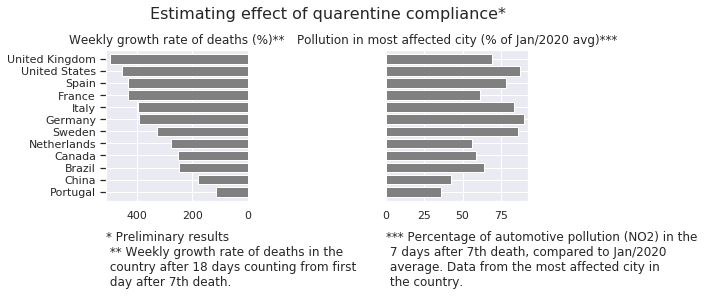

In [38]:
# df_effect_display = df_effect_final.drop('China')

df_effect_display = df_effect_final

y = np.arange(len(df_effect_display))

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 4), constrained_layout=True)

fig.suptitle('Estimating effect of quarentine compliance*', fontsize=16)

# axes[0].barh(y, (df_effect_display.Total - 1) * 100, align='center', color='gray', zorder=10)
axes[0].barh(y, df_effect_display[effect_var[0]], align='center', color='gray', zorder=10)
axes[0].set(title=effect_var[1])
axes[1].barh(y, df_effect_display.no2 * 100, align='center', color='gray', zorder=10)
axes[1].set(title='Pollution in most affected city (% of Jan/2020 avg)***')

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=df_effect_display.index)
axes[0].yaxis.tick_left()

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

# fig.tight_layout()
# fig.subplots_adjust(wspace=0.05)

annotation = "* Preliminary results\n " + effect_var[2]

annotation2 = """*** Percentage of automotive pollution (NO2) in the\n {days_to_assess_response} days after {deaths_start}th death, compared to Jan/2020\n average. Data from the most affected city in\n the country.""".format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result) 


axes[0].annotate(annotation, (0,0), (0, -30), xycoords='axes fraction', textcoords='offset points', va='top')
axes[1].annotate(annotation2, (0,0), (0, -30), xycoords='axes fraction', textcoords='offset points', va='top')


plt.show()


## Adding variables for analysis

In [39]:
df_stats = pd.read_csv(data_dir + 'backend_stats_countries.csv')

df_stats = df_stats.query("variable == 'Day10thDeath'")

df_stats

Country      variable  value
2                      Afghanistan  Day10thDeath  99.00
15                         Albania  Day10thDeath  89.00
28                         Algeria  Day10thDeath  81.00
41                         Andorra  Day10thDeath  92.00
78                       Argentina  Day10thDeath  87.00
91                         Armenia  Day10thDeath 101.00
116                      Australia  Day10thDeath  86.00
129                        Austria  Day10thDeath  83.00
142                     Azerbaijan  Day10thDeath 102.00
155                        Bahamas  Day10thDeath 115.00
168                        Bahrain  Day10thDeath 135.00
181                     Bangladesh  Day10thDeath  98.00
206                        Belarus  Day10thDeath  98.00
219                        Belgium  Day10thDeath  79.00
280                        Bolivia  Day10thDeath  95.00
293         Bosnia and Herzegovina  Day10thDeath  92.00
318                         Brazil  Day10thDeath  81.00
355                       Bulgaria  Day10thDeath  93.00
368                   Burkina Faso  Day10thDeath  91.00
405                       Cameroon  Day10thDeath 100.00
418                         Canada  Day10thDeath  80.00
467                           Chad  Day10thDeath 124.00
480                          Chile  Day10thDeath  92.00
493                          China  Day10thDeath  22.00
506                       Colombia  Day10thDeath  90.00
519                          Congo  Day10thDeath 123.00
532                     Costa Rica  Day10thDeath 138.00
545                  Cote d'Ivoire  Day10thDeath 112.00
558                        Croatia  Day10thDeath  96.00
571                           Cuba  Day10thDeath  99.00
596                         Cyprus  Day10thDeath 101.00
609                 Czech Republic  Day10thDeath  89.00
622   Democratic Republic of Congo  Day10thDeath  93.00
635                        Denmark  Day10thDeath  82.00
648                       Djibouti  Day10thDeath 143.00
673             Dominican Republic  Day10thDeath  86.00
686                        Ecuador  Day10thDeath  83.00
699                          Egypt  Day10thDeath  83.00
712                    El Salvador  Day10thDeath 122.00
725              Equatorial Guinea  Day10thDeath 143.00
750                        Estonia  Day10thDeath  94.00
799                        Finland  Day10thDeath  90.00
812                         France  Day10thDeath  68.00
837                          Gabon  Day10thDeath 136.00
862                        Georgia  Day10thDeath 130.00
875                        Germany  Day10thDeath  76.00
888                          Ghana  Day10thDeath 116.00
913                         Greece  Day10thDeath  82.00
962                      Guatemala  Day10thDeath 114.00
975                         Guinea  Day10thDeath 127.00
1000                        Guyana  Day10thDeath 127.00
1013                         Haiti  Day10thDeath 126.00
1026                      Honduras  Day10thDeath  92.00
1039                       Hungary  Day10thDeath  85.00
1052                       Iceland  Day10thDeath 112.00
1065                         India  Day10thDeath  86.00
1078                     Indonesia  Day10thDeath  80.00
1091                          Iran  Day10thDeath  56.00
1104                          Iraq  Day10thDeath  78.00
1117                       Ireland  Day10thDeath  87.00
1130                   Isle of Man  Day10thDeath 113.00
1143                        Israel  Day10thDeath  88.00
1156                         Italy  Day10thDeath  57.00
1181                         Japan  Day10thDeath  71.00
1206                    Kazakhstan  Day10thDeath 102.00
1219                         Kenya  Day10thDeath 107.00
1232                        Kosovo  Day10thDeath 108.00
1245                        Kuwait  Day10thDeath 113.00
1258                    Kyrgyzstan  Day10thDeath 124.00
1283                        Latvia  Day10thDeath 114.00
1296                       Lebanon  Day10thDeath  9

In [40]:
df_socio = pd.read_csv(data_dir + 'socio_stats_countries.csv').rename(columns={'Name':'Country'}).drop('score', axis=1)

df_socio

Country                                           variable            value
0                                Aruba                                         Population       105,845.00
1                          Afghanistan                                         Population    37,172,386.00
2                               Angola                                         Population    30,809,762.00
3                              Albania                                         Population     2,866,376.00
4                              Andorra                                         Population        77,006.00
5                 United Arab Emirates                                         Population     9,630,959.00
6                            Argentina                                         Population    44,494,502.00
7                              Armenia                                         Population     2,951,776.00
8                  Antigua and Barbuda                                         Population        96,286.00
9                            Australia                                         Population    24,982,688.00
10                             Austria                                         Population     8,840,521.00
11                          Azerbaijan                                         Population     9,939,800.00
12                             Burundi                                         Population    11,175,378.00
13                             Belgium                                         Population    11,433,256.00
14                               Benin                                         Population    11,485,048.00
15                        Burkina Faso                                         Population    19,751,535.00
16                          Bangladesh                                         Population   161,356,039.00
17                            Bulgaria                                         Population     7,025,037.00
18                             Bahrain                                         Population     1,569,439.00
19                             Bahamas                                         Population       385,640.00
20              Bosnia and Herzegovina                                         Population     3,323,929.00
21                             Belarus                                         Population     9,483,499.00
22                              Belize                                         Population       383,071.00
23                             Bermuda                                         Population        63,973.00
24                             Bolivia                                         Population    11,353,142.00
25                              Brazil                                         Population   209,469,333.00
26                            Barbados                                         Population       286,641.00
27                              Brunei                                         Population       428,962.00
28                              Bhutan                                         Population       754,394.00
29                            Botswana                                         Population     2,254,126.00
30            Central African Republic                                         Population     4,666,377.00
31                              Canada                                         Population    37,057,765.00
32                         Switzerland                                         Population     8,513,227.00
33                               Chile                                         Population    18,729,160.00
34                               China                                         Population 1,392,730,000.00
35                       Cote d'Ivoire                                         Population    25,069,229.00
36                            Cameroon                                  

In [41]:
df_all_vars = pd.concat([df_stats, df_socio])

df_all_vars = df_all_vars.pivot(index='Country', columns='variable', values='value').reset_index()

df_all_vars

variable                           Country  Average Temperature May  Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)  Cause of death, by non-communicable diseases (% of total)  Current health expenditure (% of GDP)  Current health expenditure per capita (current US$)  Day10thDeath  GDP per capita (current US$)  International tourism, number of arrivals  Life expectancy at birth, total (years)       Population  Population ages 0-14 (% of total population)  Population ages 15-64 (% of total population)  Population ages 65 and above (% of total population)  Population density (people per sq. km of land area)  Population in urban agglomerations of more than 1 million (% of total population)  Population living in slums (% of urban population)  Prevalence of undernourishment (% of population)  Urban population (% of total population)
0                              Afghanistan                    22.46                                              36.40                                                                                                  44.10                                          10.20                                              57.25           99.00                        520.90                                        nan                                    64.13    37,172,386.00                                         43.09                                          54.32                                               2.58                                                 56.94                                                10.79                                                                              62.70                                              29.80                                     25.50
1                                  Albania                    16.87                                               2.90                                                                                                  93.10                                           6.70                                             271.54           89.00                      5,268.85                               5,340,000.00                                    78.33     2,866,376.00                                         17.67                                          68.58                                              13.74                                                104.61                                                  nan                                                                                nan                                               6.20                                     60.32
2                                  Algeria                    28.66                                              14.80                                                                                                  75.70                                           6.65                                             260.41           81.00                      4,114.72                               2,657,000.00                                    76.50    42,228,429.00                                         30.15                                          63.49                                               6.36                                                 17.73                                                 6.38                                                                              11.80                                               3.90                                     72.63
3                                  Andorra                    14.84                                                nan                                                                                                    nan                                          10.37                                           3,834.73           92.00                     42,029.76                               3,042,000.00                

In [42]:
df_all_vars = df_effect_final.join(df_all_vars.set_index('Country'), how='left')

df_all_vars

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate     Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths  no2  Average Temperature May  Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)  Cause of death, by non-communicable diseases (% of total)  Current health expenditure (% of GDP)  Current health expenditure per capita (current US$)  Day10thDeath  GDP per capita (current US$)  International tourism, number of arrivals  Life expectancy at birth, total (years)       Population  Population ages 0-14 (% of total population)  Population ages 15-64 (% of total population)  Population ages 65 and above (% of total population)  Population density (people per sq. km of land area)  Population in urban agglomerations of more than 1 million (% of total population)  Population living in slums (% of urban population)  Prevalence of undernourishment (% of population)  \
Country                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Portugal               9.72              28.75                0.10                       nan        1.13              1.21 12,442.00       345.00         67.16              115.62 0.36                    17.53                                              10.20                                                                                                  85.60                                           9.08                                           1,800.86           82.00                     23,407.91                              16,186,000.00                                    81.12    10,283,822.00                                         13.46                                          64.59                                              21.95                                                112.24                                                41.18                                                                                nan                                               2.50   
China                 65.83              42.53                0.24                      0.24        1.26              1.23 34,625.00       723.00        193.21              179.15 0.43                    14.62                                               3.80                                                                                                  89.30                                           4.98                                             398.33           22.00                      9,770.85                              62,900,000.00                                    76.47 1,392,730,000.00                                         17.88                                          71.20                                              10.92                                                148.35                                                27.89                                                                              25.20                                               8.60   
Brazil                13.34 

## Analysis

Correlations and p-values for the effect and response variables.

Effect variables: 

* Weekly Growth (how much weekly growth of cases has increased)
* Total (how much total number of cases has increased)

Response variable:

* no2 (how much polution was measured in comparison with the historic average (3 years)

In [43]:
from scipy.stats import pearsonr

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

df_corr = df_all_vars.corr(method='pearson', min_periods = 6)
df_p = df_all_vars.corr(method=pearsonr_pval, min_periods = 6)

#display()

#display()

df_corr.round(2).applymap(str) + ' (' + df_p.round(2).applymap(str) + ')'

Total_ratio TotalDeaths_ratio WeeklyGrowth_ratio WeeklyGrowthDeaths_ratio    Total_rate TotalDeaths_rate         Total   TotalDeaths  WeeklyGrowth WeeklyGrowthDeaths           no2 Average Temperature May Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total) Cause of death, by non-communicable diseases (% of total) Current health expenditure (% of GDP) Current health expenditure per capita (current US$)  Day10thDeath GDP per capita (current US$) International tourism, number of arrivals Life expectancy at birth, total (years)    Population Population ages 0-14 (% of total population) Population ages 15-64 (% of total population) Population ages 65 and above (% of total population) Population density (people per sq. km of land area) Population in urban agglomerations of more than 1 million (% of total population) Population living in slums (% of urban population)  \
Total_ratio                                            1.0 (1.0)      -0.01 (0.97)         0.85 (0.0)                nan (nan)     0.9 (0.0)     -0.09 (0.79)   0.03 (0.94)  -0.02 (0.95)    0.93 (0.0)        0.39 (0.21)   0.31 (0.33)             0.07 (0.83)                                        -0.33 (0.3)                                                                                           0.19 (0.55)                                  0.44 (0.16)                                        0.51 (0.09)   -0.47 (0.12)                  0.24 (0.45)                               0.65 (0.02)                            -0.24 (0.46)   0.36 (0.26)                                  0.18 (0.58)                                    0.1 (0.75)                                        -0.17 (0.6)                                          -0.17 (0.6)                                          0.33 (0.3)                                                                         nan (nan)   
TotalDeaths_ratio                                   -0.01 (0.97)         1.0 (1.0)       -0.31 (0.33)                nan (nan)   0.26 (0.42)       0.97 (0.0)   0.38 (0.23)    0.7 (0.01)   -0.1 (0.76)        0.65 (0.02)   0.35 (0.26)             0.16 (0.61)                                       -0.18 (0.58)                                                                                           0.36 (0.25)                                 -0.24 (0.46)                                       -0.17 (0.59)   -0.05 (0.88)                  0.02 (0.96)                               0.37 (0.24)                             0.47 (0.12)  -0.27 (0.39)                                 -0.32 (0.31)                                  -0.34 (0.27)                                         0.4 (0.19)                                          0.46 (0.13)                                        -0.52 (0.09)                                                                         nan (nan)   
WeeklyGrowth_ratio                                    0.85 (0.0)      -0.31 (0.33)          1.0 (1.0)                nan (nan)   0.58 (0.05)     -0.35 (0.26)  -0.09 (0.79)  -0.23 (0.47)    0.96 (0.0)        0.33 (0.29)   0.35 (0.26)            -0.02 (0.95)                                       -0.15 (0.65)                                                                                           0.03 (0.93)                                   0.76 (0.0)                                         0.78 (0.0)   -0.07 (0.84)                  0.48 (0.11)                               0.36 (0.26)                            -0.28 (0.39)   0.11 (0.74)                                   0.3 (0.34)                                    0.0 (0.99)                                       -0.17 (0.59)                                         -0.23 (0.47)                                         0.43 (0.16)                                                                         nan (nan)   
WeeklyGrowthDeaths_ratio                               nan (nan)         nan (nan)          nan (nan)                nan (nan)     nan (nan) 

In [44]:
sns.scatterplot(x='no2', y=effect_var[0], data=df_effect_display)

In [45]:
sns.scatterplot(x='WeeklyGrowth', y='no2', data=df_effect_final)

In [46]:
result_ols = smf.ols("WeeklyGrowth ~ no2", data=df_effect_display).fit()

print("n=", len(df_effect_display))

result_ols.summary()

n= 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           WeeklyGrowth   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.645
Date:                Thu, 28 May 2020   Prob (F-statistic):              0.229
Time:                        18:30:27   Log-Likelihood:                -78.731
No. Observations:                  12   AIC:                             161.5
Df Residuals:                      10   BIC:                             162.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -58.4638    221.341     -0.264      0.797    -551.643     434.715
no2          407.0373    317.324      1.283      0.229    -300.005    1114.080
==============================================================================
Omnibus:                       18.415   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.825
Skew:                           1.901   Prob(JB):                     0.000995
Kurtosis:                       6.633   Cond. No.                         8.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""